In [11]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.spatial
import pandas as pd
import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing
from sklearn.decomposition import PCA
# %matplotlib inline
# Dimension reduction and clustering libraries
# import umap
# import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import LeaveOneOut,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import pairwise_distances,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from utils.readProfiles import readMergedProfiles
from utils.pred_models import *
from utils.saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile

# from utils import networksEvol, tsne, readProfiles
# import umap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.__version__

'1.1.1'

#### In this notebook we test how combinting two data modalities will improve preformance of the following tasks:
    1 - MOA prediction
    2 - ?

## MoA Prediction:
- Data Fusion Methods:
    - Early Fusion: simple concatenation
    - Late Fusion: desision probabilty average
    - SNF
    - CCA

## Datasets and MoA annotations:

#### LINCS
- Full Set:
    - 568 unique multi-label MoAs (163 of these labels have more than 1 moa label)
    
- Filt Set:
    - 284 unique multi-label MoAs (74 of these labels have more than 1 moa label)
    


#### CDRP-bio
- Full Set:
    - xx unique multi-label MoAs (74 of these labels have more than 1 moa label)
    
- Filt Set:
    - xx unique multi-label MoAs (163 of these labels have more than 1 moa label)
    
    
#### CDRP
- Full Set:
    - xx unique multi-label MoAs (74 of these labels have more than 1 moa label)
    
- Filt Set:
    - xx unique multi-label MoAs (163 of these labels have more than 1 moa label)
    


### Paths

In [12]:
procProf_dir='/home/ubuntu/datasetsbucket/Rosetta-GE-CP/'
# procProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/'
metadata_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/'
results_dir='./results/'

### Read GE and CP profiles 

In [13]:
################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
dataset='LINCS'


################################################
# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
profileType='normalized_variable_selected'
profTypeAbbrev=''.join([s[0] for s in profileType.split('_')])

################################################
# filtering to compounds which have high replicates for both GE and CP datasets
# highRepOverlapEnabled=0
# 'highRepUnion','highRepOverlap'
filter_perts='highRepUnion'


################################################
pertColName='PERT'
profileLevel='treatment'; #'replicate'  or  'treatment'
if filter_perts:
    f='filt'
else:
    f=''

nRep=1
mergProf_repLevel,mergProf_treatLevel,cp_features,l1k_features=\
readMergedProfiles(procProf_dir,dataset,profileType,profileLevel,nRep,filter_perts);

moa_col='Metadata_MoA'

##################################
if dataset=='LINCS':
    mergProf_treatLevel[moa_col]=mergProf_treatLevel['Metadata_moa']
    mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),moa_col]=\
    mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),'moa'].str.lower()
    mergProf_treatLevel['Compounds']=mergProf_treatLevel['PERT'].str[0:13]
    
elif dataset=='CDRP-bio':
    mergProf_treatLevel[moa_col]=mergProf_treatLevel['Metadata_moa'].str.lower()
    mergProf_treatLevel['Compounds']=mergProf_treatLevel['PERT'].str[0:13]

# mergProf_repLevel,mergProf_treatLevel,l1k_features,cp_features,pertColName=readMergedProfiles(dataset,profileType,nRep)
# cp_features,l1k_features=cp_features.tolist(),l1k_features.tolist()
# mergProf_repLevel['Compounds']=mergProf_repLevel['PERT'].str[0:13]

if profileLevel=='replicate':
    l1k=mergProf_repLevel[[pertColName]+l1k_features]
    cp=mergProf_repLevel[[pertColName]+cp_features]
elif profileLevel=='treatment':
    l1k=mergProf_treatLevel[[pertColName,'Compounds',moa_col]+l1k_features]
    cp=mergProf_treatLevel[[pertColName,'Compounds',moa_col]+cp_features]


scaler_ge = preprocessing.StandardScaler()
scaler_cp = preprocessing.StandardScaler()
l1k_scaled=l1k.copy()
l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
cp_scaled=cp.copy()
cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))


if 1:
    cp_scaled[cp_features] =preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(cp_scaled[cp_features].values)   
    l1k_scaled[l1k_features] =preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(l1k_scaled[l1k_features].values)           

    
merged_scaled=pd.concat([cp_scaled, l1k_scaled], axis=1)
merged_scaled = merged_scaled.loc[:,~merged_scaled.columns.duplicated()]    
merged_scaled['Compounds']=merged_scaled['PERT'].str[0:13]



#################### keep MOAs with more than "nSamplesMOA" compounds in their class

nSamplesMOA=4

nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Compounds']).sample(1).groupby([moa_col]).size().\
reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)


nSamplesforEachMOAclass2=mergProf_treatLevel.groupby([moa_col]).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)

listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>nSamplesMOA][moa_col].tolist()
print('If we filter to MoAs which have more than',nSamplesMOA,' compounds in their category, ',\
      len(listOfSelectedMoAs),' out of ',nSamplesforEachMOAclass.shape[0] ,' MoAs remain.')



multi_label_MoAs=[l for l in listOfSelectedMoAs if '|' in l]
print('There are ',len(listOfSelectedMoAs),'MoA categories, which out of them ',len(multi_label_MoAs),\
      ' have multi labels and is removed')

listOfSelectedMoAs=[ele for ele in listOfSelectedMoAs if ele not in multi_label_MoAs]

le = preprocessing.LabelEncoder()
le.fit(listOfSelectedMoAs)

# IDs4filteredMOAs=mergProf_treatLevel[mergProf_treatLevel[moa_col].isin(listOfSelectedMoAs)][pertColName].unique().tolist()

filteredMOAs=merged_scaled[merged_scaled[moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True)
data4eval=[[cp_scaled[cp_scaled[moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True),cp_features],\
           [l1k_scaled[l1k_scaled[moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True),l1k_features],\
           [filteredMOAs,cp_features+l1k_features]]

filteredMOAs['Metadata_moa_num']=le.transform(filteredMOAs[moa_col].tolist())

# nSamplesMOA=0 and union
print("There are ", filteredMOAs.shape[0],"samples across different doses of ",filteredMOAs['Compounds'].unique().shape[0] ,\
      "compounds", ", for ",filteredMOAs["Metadata_MoA"].unique().shape[0], "MoAs")

/tmp/ipykernel_26330/1425533454.py:28: DtypeWarning: Columns (18,19,1249,1250) have mixed types.Specify dtype option on import or set low_memory=False.
  readMergedProfiles(procProf_dir,dataset,profileType,profileLevel,nRep,filter_perts);


LINCS: Replicate Level Shapes (nSamples x nFeatures): cp:  52223 , 119 ,  l1k:  27837 , 978
l1k n of rep:  3.0
cp n of rep:  5.0
CP: from  9394  to  4647
l1k: from  8369  to  2338
CP and l1k high rep union:  5845
Treatment Level Shapes (nSamples x nFeatures+metadata): (5243, 122) (4431, 980) Merged Profiles Shape: (3828, 1101)
If we filter to MoAs which have more than 4  compounds in their category,  58  out of  514  MoAs remain.
There are  58 MoA categories, which out of them  1  have multi labels and is removed
There are  1655 samples across different doses of  521 compounds , for  57 MoAs


### LINCS Filtered sets

* Overlap:   
    - LINCS: Replicate Level Shapes (nSamples x nFeatures): cp:  52223 , 119 ,  l1k:  27837 , 978
    - l1k n of rep:  3.0
    - cp n of rep:  5.0
    - CP: from  9394  to  4647
    - l1k: from  8369  to  2338
    - CP and l1k high rep overlap:  1140
    - Treatment Level Shapes (nSamples x nFeatures+metadata): (1141, 122) (1141, 980) Merged Profiles Shape: (1141, 1101)
    - If we filter to MoAs which have more than 4  compounds in their category,  20  out of  284  MoAs remain.
    - There are  20 MoA categories, which out of them  0  have multi labels
    - There are  421 samples across different doses of  149 compounds , for  20 MoAs
        
* Union:
    - LINCS: Replicate Level Shapes (nSamples x nFeatures): cp:  52223 , 119 ,  l1k:  27837 , 978
    - l1k n of rep:  3.0
    - cp n of rep:  5.0
    - CP: from  9394  to  4647
    - l1k: from  8369  to  2338
    - CP and l1k high rep union:  5845
    - Treatment Level Shapes (nSamples x nFeatures+metadata): (5243, 122) (4431, 980) Merged Profiles Shape: (3828, 1101)
    - If we filter to MoAs which have more than 4  compounds in their category,  58  out of  514  MoAs remain.
    - There are  58 MoA categories, which out of them  1  have multi labels and is removed.
    - There are  1655 samples across different doses of  521 compounds , for  57 MoAs

In [70]:
# nSamplesforEachMOAclass

In [71]:
# multi_label_MoAs=[l for l in listOfSelectedMoAs if '|' in l]

In [17]:
# len([u.split('|') for u in unq if '|' in u])
mergProf_treatLevel[moa_col]=mergProf_treatLevel['Metadata_moa']
mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),moa_col]=\
mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),'moa'].str.lower()
mergProf_treatLevel['Metadata_MoA'].unique().shape

(514,)

In [351]:
mergProf_treatLevel[moa_col]=mergProf_treatLevel['Metadata_moa']
mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),moa_col]=\
mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),'moa'].str.lower()
mergProf_treatLevel['Metadata_MoA'].unique().shape

(568,)

In [347]:
unq=mergProf_treatLevel['Metadata_MoA'].unique().tolist()
target_moa_labels=[]
for u in unq:
    target_moa_labels=target_moa_labels+u.split('|');

In [350]:
len(target_moa_labels),len(set(target_moa_labels))

(784, 478)

#### Number of Classes with more than one label

<IPython.core.display.Javascript object>


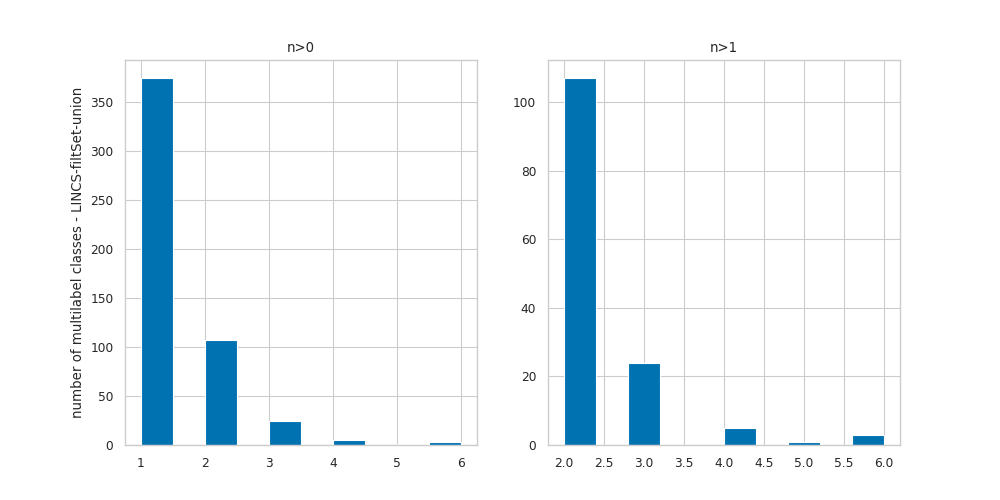

In [84]:
unq=mergProf_treatLevel['Metadata_MoA'].unique().tolist()
# n_multi_l=[len(u.split('|')) for u in unq if '|' in u]

fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].hist([len(u.split('|')) for u in unq]);
axes[0].set_title('n>0');
axes[0].set_ylabel('number of multilabel classes - LINCS-filtSet-union');

axes[1].hist([len(u.split('|')) for u in unq if '|' in u]);
axes[1].set_title('n>1');#axes[1].set_ylabel('number of multilabel classes');

#### Number of Samples with more than one label

<IPython.core.display.Javascript object>


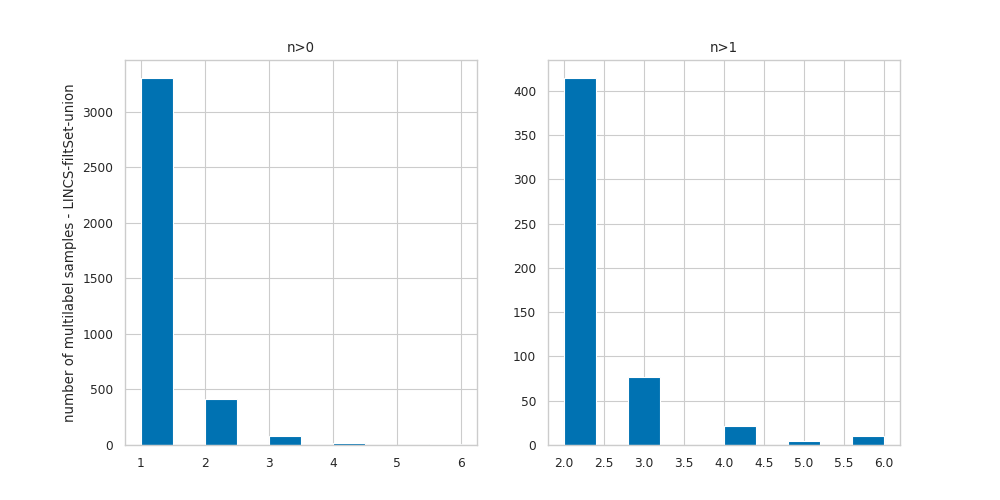

In [87]:
unq=mergProf_treatLevel['Metadata_MoA'].tolist()
# n_multi_l=[len(u.split('|')) for u in unq if '|' in u]

fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].hist([len(u.split('|')) for u in unq]);
axes[0].set_title('n>0');axes[0].set_ylabel('number of multilabel samples - LINCS-filtSet-union');

axes[1].hist([len(u.split('|')) for u in unq if '|' in u]);
axes[1].set_title('n>1');#axes[1].set_ylabel('number of multilabel samples');

In [32]:


mergProf_treatLevel.columns[mergProf_treatLevel.columns.str.contains('moa')]
# list(set(mergProf_treatLevel.columns.tolist())-set(cp_features))

Index(['Metadata_moa', 'Metadata_alternative_moa', 'moa'], dtype='object')

In [75]:
mergProf_treatLevel[['Metadata_moa', 'Metadata_alternative_moa', 'moa',moa_col]]

,Metadata_moa,Metadata_alternative_moa,moa,Metadata_MoA
0,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
1,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
2,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
3,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
4,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
...,...,...,...,...
6980,NaN,NaN,Potassium channel activator,potassium channel activator
6981,NaN,NaN,Potassium channel activator,potassium channel activator
6982,NaN,NaN,Potassium channel activator,potassium channel activator
6983,NaN,NaN,Potassium channel activator,potassium channel activator


In [31]:
mergProf_treatLevel[['Metadata_moa', 'Metadata_alternative_moa', 'moa',moa_col]]

,Metadata_moa,Metadata_alternative_moa,moa,Metadata_MoA
0,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
1,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
2,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
3,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
4,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
...,...,...,...,...
1136,potassium channel activator,NaN,Potassium channel activator,potassium channel activator
1137,potassium channel activator,NaN,Potassium channel activator,potassium channel activator
1138,Abl kinase inhibitor|Bcr-Abl kinase inhibitor|...,NaN,Src inhibitor|Abl kinase inhibitor|Bcr-Abl kin...,Abl kinase inhibitor|Bcr-Abl kinase inhibitor|...
1139,NaN,NaN,Dopamine receptor antagonist,Dopamine receptor antagonist


In [21]:
mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isnull()]['moa']

134                  Rho associated kinase inhibitor
135                  Rho associated kinase inhibitor
136                  Rho associated kinase inhibitor
137                  Rho associated kinase inhibitor
147                                   MTOR inhibitor
148                                   MTOR inhibitor
149                                   MTOR inhibitor
150                                   MTOR inhibitor
151                                   MTOR inhibitor
170                  Glucocorticoid receptor agonist
171                  Glucocorticoid receptor agonist
172                  Glucocorticoid receptor agonist
173                  Glucocorticoid receptor agonist
174                  Glucocorticoid receptor agonist
228     Methylmalonyl CoA mutase stimulant|Vitamin B
252                        Potassium channel blocker
394                  Benzodiazepine receptor agonist
465                  Rho associated kinase inhibitor
466                  Rho associated kinase inh

In [63]:
# mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isnull()]['moa']

In [78]:
# mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isnull()].shape

(195, 1103)

In [40]:
# mergProf_treatLevel[mergProf_treatLevel['Metadata_MoA'].isnull()].shape

In [72]:
# cp['Compounds'],cp['PERT']
# pd.merge(nSamplesforEachMOAclass,nSamplesforEachMOAclass2,how='inner',on=[moa_col])

In [79]:
# pd.concat([nSamplesforEachMOAclass,nSamplesforEachMOAclass2])
# nSamplesforEachMOAclass
nSamplesforEachMOAclass

,Metadata_moa,size
0,adrenergic receptor antagonist,75
1,glucocorticoid receptor agonist,73
2,phosphodiesterase inhibitor,71
3,cyclooxygenase inhibitor,70
4,histamine receptor antagonist,56
...,...,...
496,stearoyl-CoA desaturase inhibitor,1
497,angiotensin converting enzyme activator,1
498,NADPH inhibitor,1
499,calmodulin antagonist,1


<ipython-input-88-683e67e481f8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nSamplesforEachMOAclass_['h']='n-compounds'
<ipython-input-88-683e67e481f8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nSamplesforEachMOAclass2_['h']='n-samples'


<IPython.core.display.Javascript object>


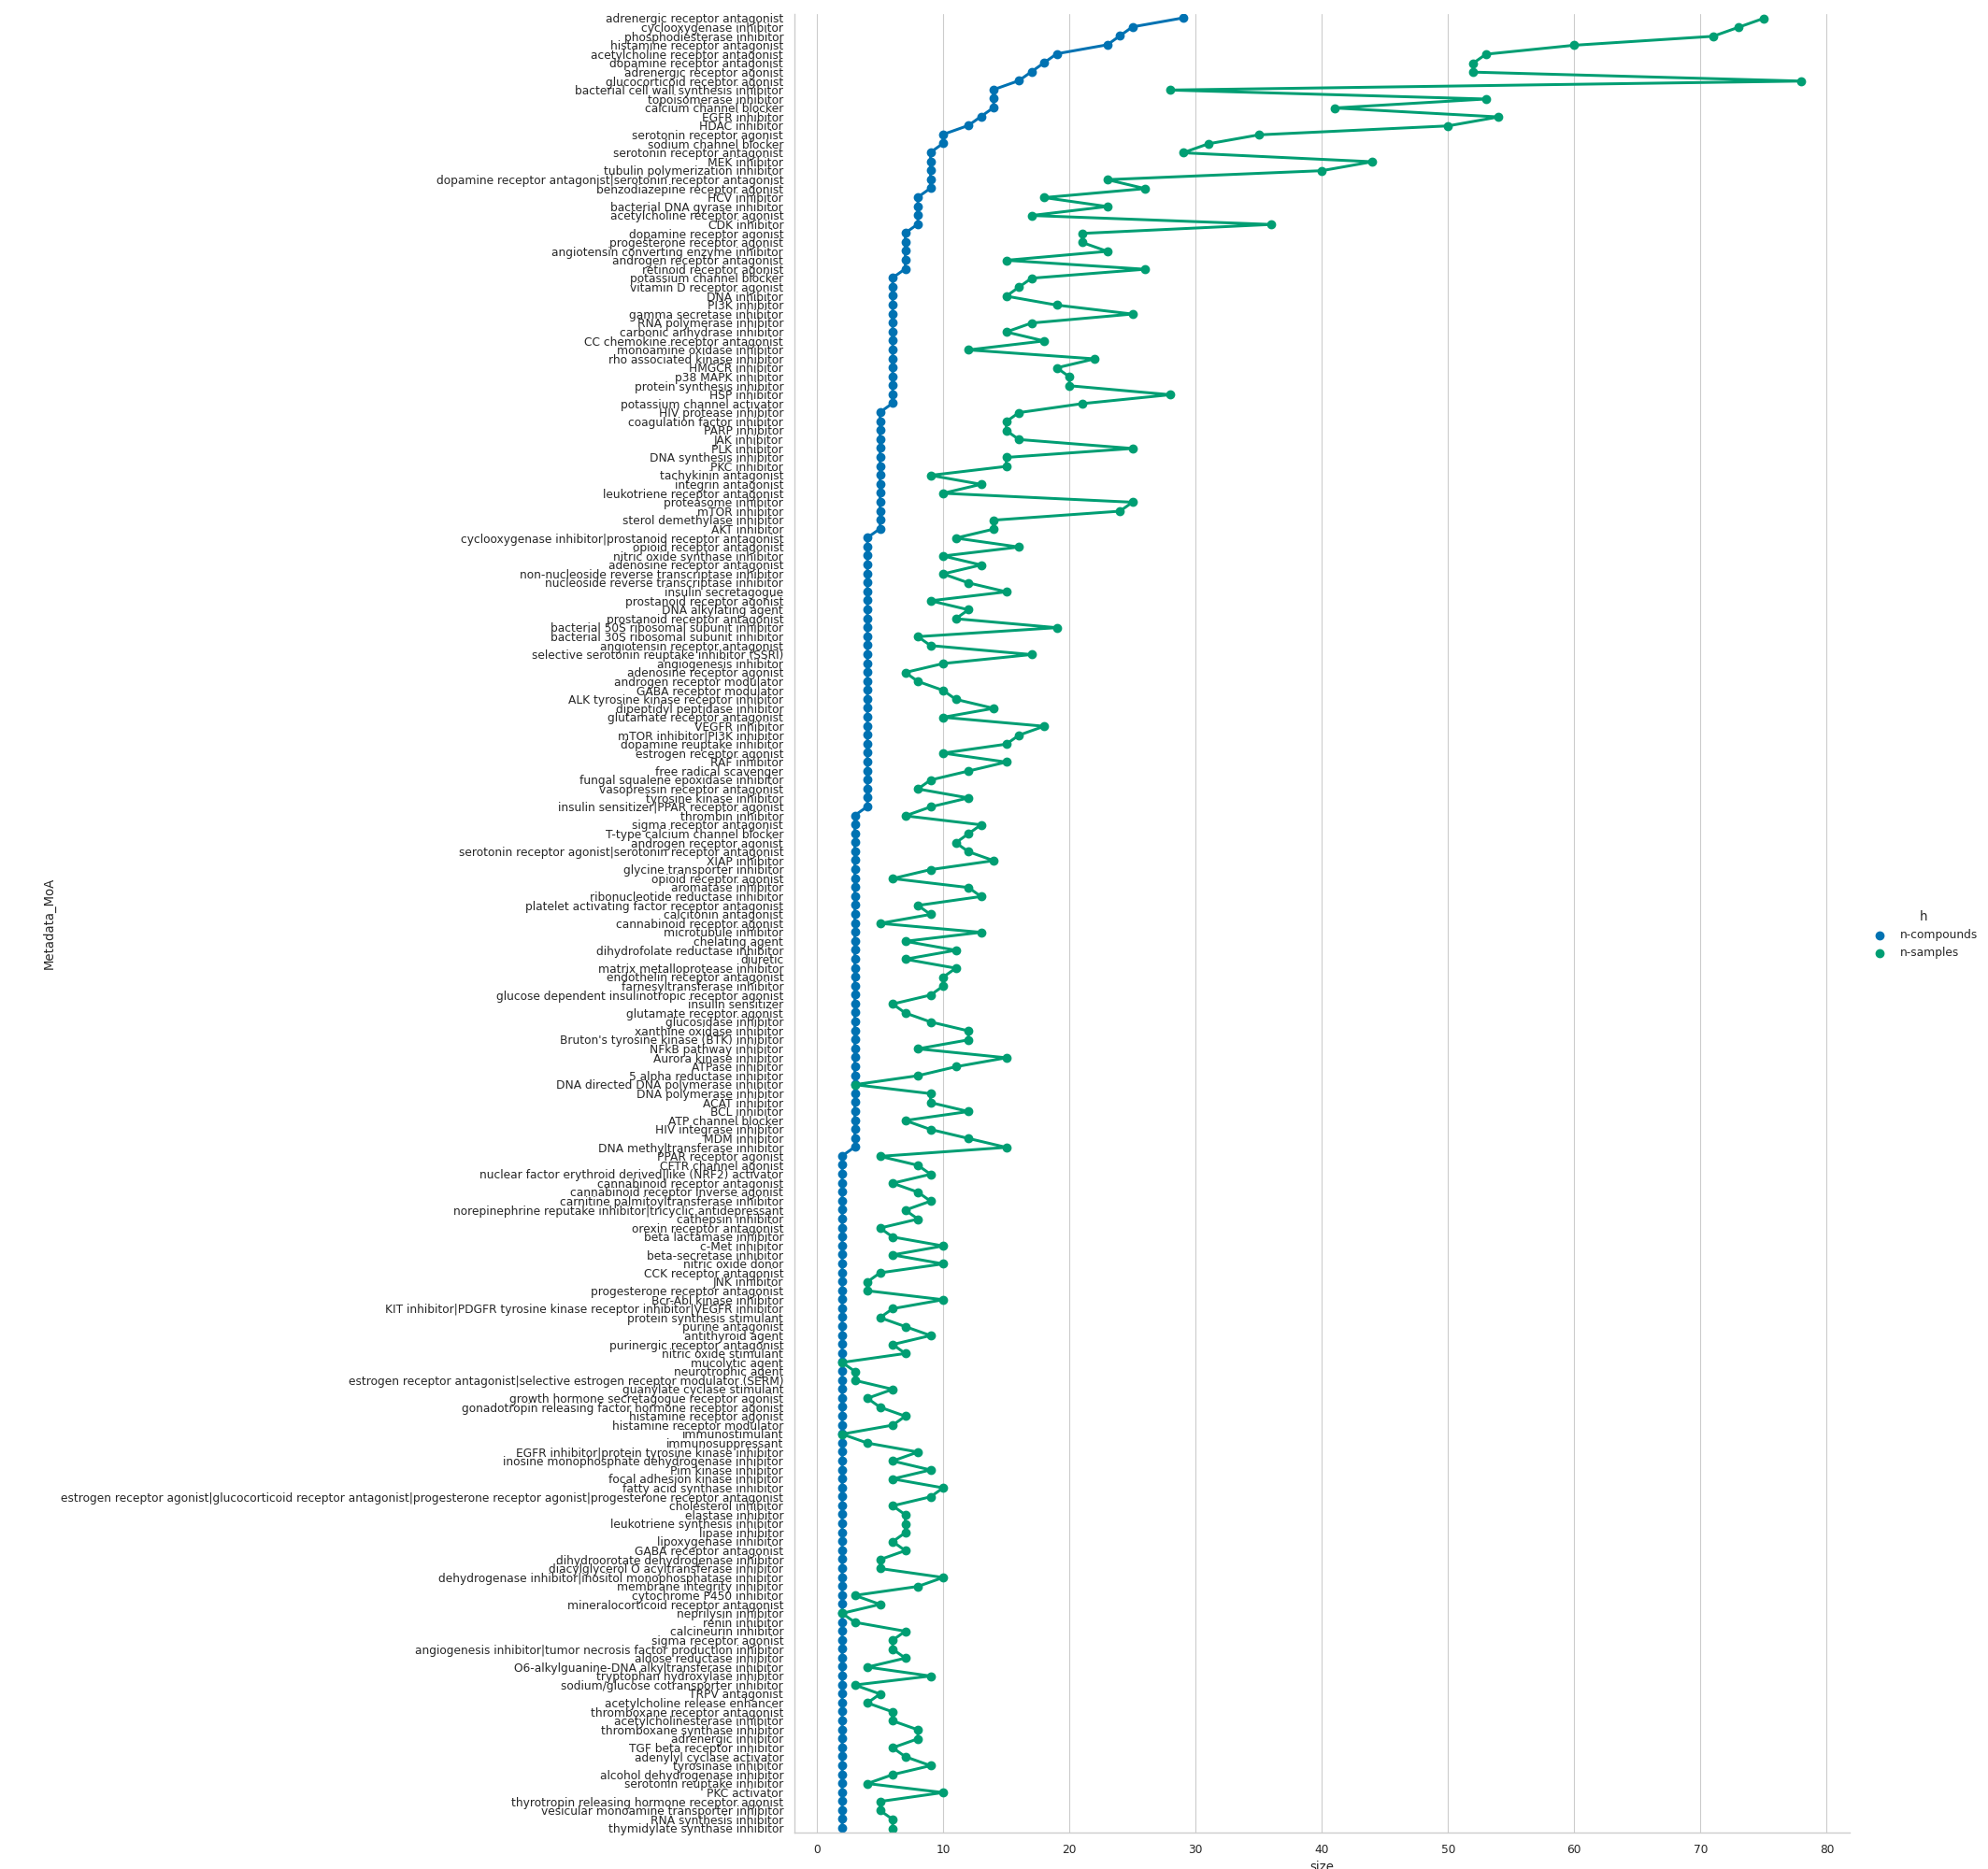

In [88]:
# plt.figure()
# fig, axes = plt.subplots(figsize=(20,5))
# nSamplesforEachMOAclass3=pd.merge(nSamplesforEachMOAclass,nSamplesforEachMOAclass2,how='inner',on=[moa_col])
nSamplesforEachMOAclass_=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]
nSamplesforEachMOAclass2_=nSamplesforEachMOAclass2[nSamplesforEachMOAclass2[moa_col].isin(nSamplesforEachMOAclass_[moa_col].tolist())]
nSamplesforEachMOAclass_['h']='n-compounds'
nSamplesforEachMOAclass2_['h']='n-samples'

nSamplesforEachMOAclass3=pd.concat([nSamplesforEachMOAclass_,nSamplesforEachMOAclass2_])

sns.catplot(x="size",y=moa_col, data=nSamplesforEachMOAclass3[nSamplesforEachMOAclass3['size']>1],\
            orient="h", height=20, aspect=1,hue='h',
                kind="point", dodge=True, cut=0, bw=.2)
# fig.tight_layout()

In [139]:
# mergProf_treatLevel.groupby(['moa']).size().reset_index().rename(columns={0:'nrep'}).sort_values(by='nrep')
# moa_col='moa'

In [89]:
# nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
# listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]['Metadata_moa'].tolist()
# print(len(listOfSelectedMoAs))

In [90]:
# # mergProf_treatLevel['Metadata_moa']=mergProf_treatLevel['Metadata_moa'].str.lower()
# nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
# listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]['Metadata_moa'].tolist()
# print(len(listOfSelectedMoAs))

In [91]:
# listOfSelectedMoAs
# filteredMOAs['Metadata_moa_num']#=le.transform(filteredMOAs[moa_col].tolist())
# filteredMOAs[moa_col].tolist()

In [92]:
# nSamplesforEachMOAclass

In [1]:
# IDs4filteredMOAs

In [38]:
# nSamplesforEachMOAclass
# IDs4filteredMOAs
# pd.DataFrame(index=filteredMOAs['Compounds'].values,columns=['CP','GE','Early Fusion','Late Fusion'])
filteredMOAs.loc[test_index,'Compounds'].unique()[0]

'BRD-A03506276'

### MoA prediction using each dataset and early and late fusion of datasets

In [ ]:
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, GroupKFold,LeaveOneGroupOut
from sklearn.neural_network import MLPClassifier
# domXdata=merged_scaled.copy();
# domXfeats=data4eval[r][1]
# outdim_size=40

# filteredMOAs=domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
# filteredMOAs['Metadata_moa_num']=le.transform(filteredMOAs[moa_col].tolist())

moa_pred_res=pd.DataFrame(index=filteredMOAs['Compounds'].values,columns=['CP','GE','Early Fusion',\
                                                                          'Late Fusion','Metadata_moa_num'])

# n_of_random_sel=20
# n_of_random_sel=50
# n_folds=5
# acc_array_fullSet2_cdrp=np.zeros((n_of_random_sel,4));
# acc_array_filtSet2_cdrp=np.zeros((n_of_random_sel,4));
# for i in range(n_of_random_sel):

#     split_obj=GroupKFold(n_splits=k)
# #     split_obj = LeaveOneGroupOut()    
#     # Perform k-fold cross validation
#     scores = cross_val_score(clf, X, y, groups=group_labels,cv=split_obj,n_jobs=n_j)

# kf = KFold(n_splits=n_folds,random_state=1,shuffle=True)
# gkf=GroupKFold(n_splits=n_folds)


parameter_space_MLP = {
    'hidden_layer_sizes': [(50,),(100,),(200)],
    'activation': ['tanh'],
    'alpha': [0.0001],
}

# parameter_space_MLP = {
#     'hidden_layer_sizes': [(10,30,10),(20,)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],
# }


# parameter_space_logistic={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
parameter_space_logistic={"C":[500,1000,1500]}

from sklearn.model_selection import GridSearchCV



logo = LeaveOneGroupOut()

leG = preprocessing.LabelEncoder()
group_labels=leG.fit_transform(filteredMOAs['Compounds'].values)

i=0
# for train_index0, test_index in gkf.split(filteredMOAs, groups=group_labels):
for train_index, test_index in logo.split(filteredMOAs, groups=group_labels):
    print('rand ',i)
    i+=1
    
#     data_train = filteredMOAs.loc[train_index,domXfeats].values;
    labels_train=filteredMOAs.loc[train_index,'Metadata_moa_num'].tolist()
#     print(filteredMOAs.loc[train_index,'Metadata_moa_num'].unique().shape)
    
#     data_test = filteredMOAs.loc[test_index,domXfeats].values;
    labels_test=filteredMOAs.loc[test_index,'Metadata_moa_num'].tolist()
#     print(filteredMOAs.loc[test_index,'Metadata_moa_num'].unique().shape)    
    
    class_weightt = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)    
#         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")

    probs=[]
    for n,dt_modality,col in zip([0,1,2],data4eval,['CP','GE','Early Fusion']):
        
        data_m=dt_modality[0]   

        dt_train=data_m.loc[train_index,dt_modality[1]].values;
        dt_test=data_m.loc[test_index,dt_modality[1]].values; 
    #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
#         model_tr = GaussianNB()
#         model_tr = ComplementNB()

#         model_tr = RandomForestClassifier(n_estimators=10)

        model_logistic = LogisticRegression(multi_class='multinomial',max_iter=1000,class_weight="balanced")        
        model_tr = GridSearchCV(model_logistic, parameter_space_logistic, n_jobs=4, cv=2)
        
#         model_MLP = MLPClassifier(max_iter=100)
#         model_tr = GridSearchCV(model_MLP, parameter_space_MLP, n_jobs=4, cv=2)
    
        model_tr.fit(dt_train,labels_train)
        print(model_tr.best_params_)
#         accc=model_tr.score(dt_test,labels_test)
#         print(model_tr.predict(dt_test))
#         accc=f1_score(labels_test,model_tr.predict(dt_test), average='weighted')        
        moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=model_tr.predict(dt_test)
#         moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=accc*100
        probs.append(model_tr.predict_proba(dt_test))

#     labels_lateFusion=list(np.argmax((probs[0]+probs[1])/2,axis=1))
    labels_lateFusion=model_tr.classes_[np.argmax((probs[0]+probs[1])/2,axis=1)]
    moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],'Late Fusion']=\
    labels_lateFusion
    moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],'Metadata_moa_num']=\
    labels_test
#     f1_score(labels_test,labels_lateFusion, average='weighted')*100
#     accuracy_score(labels_test,labels_lateFusion)*100

moa_pred_res['Metadata_moa_num']=moa_pred_res.Metadata_moa_num.apply(lambda x: int(x[0]) if type(x)==list else x)    
print(moa_pred_res.mean())


filename=results_dir+'/MoAprediction/pred_moa.xlsx'
saveAsNewSheetToExistingFile(filename,moa_pred_res,'fC-'+dataset+'-'+profTypeAbbrev+'-'+f+'-preds-lr-ht')

# print('Accuracy: ',r, np.mean(Acc_list)*100)  

In [30]:
# moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]
# moa_pred_res,moa_pred_res
# filteredMOAs
# saveAsNewSheetToExistingFile(filename,moa_pred_res,'fuseConcat-'+dataset+'-'+profTypeAbbrev+'-'+f+'-predictions')
# moa_pred_res['CP']
# saveAsNewSheetToExistingFile(filename,moa_pred_res,'fC-'+dataset+'-'+profTypeAbbrev+'-'+f+'-preds-lr-ht')
# model_tr.best_params_
np.logspace(-3,3,7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [118]:
pd.merge(moa_pred_res,filteredMOAs[['Compounds','Metadata_moa_num']].drop_duplicates(),how='inner',on=['Compounds'])['Metadata_moa_num']

In [17]:
saveAsNewSheetToExistingFile(filename,moa_pred_res,'fC-'+dataset+'-'+profTypeAbbrev+'-'+f+'-preds-lr-ht')

fC-LINCS-nvs-filt-preds-lr-ht  saved!


In [28]:
# moa_pred_res['Compounds']=moa_pred_res.index
# moa_pred_res
moa_pred_res['Metadata_moa_num2']=moa_pred_res.Metadata_moa_num.apply(lambda x: int(x[0]) if type(x)==list else x)
f1_score(moa_pred_res['Late Fusion'].values.astype(int),moa_pred_res.Metadata_moa_num2.values, average='weighted')

0.7673626288966213

In [158]:
moa_pred_res['Metadata_moa_num2']

BRD-A03506276    14
BRD-A03506276    14
BRD-A03506276    14
BRD-A03506276    14
BRD-A03506276    14
                 ..
BRD-K99475619    84
BRD-K99604664    71
BRD-K99604664    71
BRD-K99604664    71
BRD-M80207679    45
Name: Metadata_moa_num2, Length: 752, dtype: int64

In [105]:

# moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=model_tr.predict(dt_test)
moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]

BRD-A03506276    14
BRD-A03506276    14
BRD-A03506276    14
BRD-A03506276    62
BRD-A03506276    62
Name: CP, dtype: object

In [97]:
# moa_pred_res['Late Fusion']=moa_pred_res['Late Fusion']*100
# print(moa_pred_res.mean())
# saveAsNewSheetToExistingFile(filename,moa_pred_res,'fuseConcat-'+dataset+'-'+profTypeAbbrev+'-'+f+'-f1')
model_tr.predict(dt_test)

array([0])

In [33]:
le.inverse_transform(model_tr.predict(dt_test)),le.inverse_transform(labels_test)

(array(['microtubule inhibitor', 'microtubule inhibitor',
        'microtubule inhibitor', 'microtubule inhibitor',
        'microtubule inhibitor'], dtype='<U123'),
 array(['HSP inhibitor', 'HSP inhibitor', 'HSP inhibitor', 'HSP inhibitor',
        'HSP inhibitor'], dtype='<U123'))

In [61]:
# import sklearn as skl
# skl.__version__

In [63]:
# 
# _tr, filteredMOAs[cp_features[0:10]], filteredMOAs[moa_col].tolist(), groups=group_labels,cv=gkf)

In [62]:
# # scoring = {'recall0': make_scorer(recall_score, average = None}
# from sklearn.model_selection import cross_validate
# cross_validate(model_tr, filteredMOAs[cp_features[0:10]], filteredMOAs[moa_col].tolist(),\
#                 groups=group_labels,cv=gkf,scoring='balanced_accuracy', return_train_score = False)

In [64]:
# gkf=GroupKFold(n_splits=5)
# cross_val_score(model_tr, filteredMOAs[cp_features[0:10]], filteredMOAs[moa_col].tolist(),\
#                 groups=group_labels,cv=gkf,scoring='balanced_accuracy')

In [65]:
# cross_val_score(model_tr, filteredMOAs[cp_features[0:10]], filteredMOAs[moa_col].tolist(),\
#                 groups=group_labels,cv=gkf,scoring='f1_weighted')

In [85]:
# cross_val_score(model_tr, filteredMOAs[cp_features[0:10]], filteredMOAs[moa_col].tolist(),\
#                 groups=group_labels,cv=gkf,scoring='f1')

In [66]:
# cp.shape,l1k.shape,merged_scaled.shape
# merged_scaled['PERT']
# mergProf_treatLevel[moa_col].unique()
# mergProf_treatLevel
# IDs4filteredMOAs
# mergProf_treatLevel[mergProf_treatLevel[moa_col].isin(listOfSelectedMoAs)]['Compounds'].shape
# sorted(sklearn.metrics.SCORERS.keys())

In [67]:
len(listOfSelectedMoAs),len(IDs4filteredMOAs),mergProf_treatLevel.shape

(86, 752, (1141, 1103))

In [257]:
# merged_scaled['PERT']
# listOfSelectedMoAs
# cp_features
pertColName

'PERT'

In [246]:
# import os
# os.mkdir('../../results/dataIntegration')

In [228]:
len(listOfSelectedMoAs) #filt set (n>1) CDRP

14

In [296]:
len(listOfSelectedMoAs) #full set (n>1) cdrp

191

In [533]:
len(listOfSelectedMoAs) #full set (n>3)

84

In [547]:
len(listOfSelectedMoAs) #filt set(n>3)

24

In [96]:
len(listOfSelectedMoAs) #filt set (n>1)

72

In [366]:
len(listOfSelectedMoAs) #full set (n>1)

191

In [ ]:
len(listOfSelectedMoAs) #full set (n>1)

In [437]:
cp['Compounds']=cp['PERT'].str[0:13]
l1k['Compounds']=l1k['PERT'].str[0:13]

data4eval=[[cp,cp_features],[l1k,l1k_features],[merged_scaled,cp_features+l1k_features]]

In [245]:
ls ../../results/

checkpoint                 GeneVsCPfeature/
cpCategoriesHM-LINCS.png   modelW/
cpCategoriesHM.png         modelW.data-00000-of-00001
cpFeaturesGene_ccMat.csv   modelW.index
cpFeaturesGene_ccMat.eps   RepCor/
cpFeaturesGene_ccMat.pkl   results.csv
cpFeaturesGene_ccMat.png   results-nnC.csv
cpFeaturesGene_glmMat.csv  results-replicate-nnC.csv
cpFeaturesGene_glmMat.pkl  results-Treatment12120end.csv
cpFeaturesGene_glmMat.png  results-Treatment_1t0121.csv
cpFeaturesGene_miMat.csv   results-Treatment.csv
cpFeaturesGene_miMat.pkl   results-Treatment-lin-rand.csv
cpFeaturesGene_miMat.png   SingleCPfeatPred/
dataIntegration/           SingleGenePred/


In [247]:
# DataFuseResults
# pd.to_csv('../../results/dataIntegration/fusion_res.xlsx')
res_path='../../results/dataIntegration/fusion_res.xlsx'
saveAsNewSheetToExistingFile(res_path,DataFuseResults,'logisticReg')

In [363]:
saveAsNewSheetToExistingFile(res_path,DataFuseResults_loaded,'logisticReg')

[]


In [366]:
# DataFuseResults_loaded=pd.read_excel(res_path, sheet_name=None)['logisticReg']
# DataFuseResults_loaded

In [530]:
# acc_array_fullSet=np.copy(acc_array_filtSet)

In [235]:
# filteredMOAs.loc[test_index].groupby(['Metadata_moa']).sample(1).index.values

In [37]:
filteredMOAs['Metadata_moa'].unique().shape

(179,)

In [ ]:
Clustering performance

### MoA prediction using each CCA projected dataset and early and late fusion of CCA projected datasets 

In [97]:
from sklearn.cross_decomposition import CCA
from sklearn.utils import class_weight
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, GroupKFold,LeaveOneGroupOut

parameter_space_logistic={"C":[1,10]}
parameter_space_MLP = {
    'hidden_layer_sizes': [(10,),(50,),(100,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001,0.05],
}

outdim_size=40

moa_pred_res_cca=pd.DataFrame(index=filteredMOAs['Compounds'].values,columns=['CP','GE','Early Fusion','Late Fusion'])

logo = LeaveOneGroupOut()

leG = preprocessing.LabelEncoder()
group_labels=leG.fit_transform(filteredMOAs['Compounds'].values)

i=0
# for train_index0, test_index in gkf.split(filteredMOAs, groups=group_labels):
for train_index, test_index in logo.split(filteredMOAs, groups=group_labels):
    print('rand ',i)
    i+=1
    
#     data_train = filteredMOAs.loc[train_index,domXfeats].values;
    labels_train=filteredMOAs.loc[train_index,'Metadata_moa_num'].tolist()
#     print(filteredMOAs.loc[train_index,'Metadata_moa_num'].unique().shape)
    
#     data_test = filteredMOAs.loc[test_index,domXfeats].values;
    labels_test=filteredMOAs.loc[test_index,'Metadata_moa_num'].tolist()
#     print(filteredMOAs.loc[test_index,'Metadata_moa_num'].unique().shape)    
    
    class_weightt = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)    
#         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
    data_train_l1k = filteredMOAs.loc[train_index,l1k_features].values;
    data_train_cp = filteredMOAs.loc[train_index,cp_features].values;
    
    cca = CCA(n_components=outdim_size)
    cca.fit(data_train_l1k, data_train_cp)
    X_c, Y_c = cca.transform(data_train_l1k, data_train_cp)    
    
    data_train=np.concatenate((X_c, Y_c), axis=1)
    
    data_test_l1k = filteredMOAs.loc[test_index,l1k_features].values;
    data_test_cp = filteredMOAs.loc[test_index,cp_features].values;    
    X_c_2, Y_c_2 = cca.transform(data_test_l1k, data_test_cp)    
    data_test=np.concatenate((X_c_2, Y_c_2), axis=1)
    

    probs=[]
    for col,dt_train,dt_test in zip(['CP','GE','Early Fusion'],[Y_c, X_c,data_train],[Y_c_2,X_c_2,data_test]):
#         print(n)
#         class_weightt = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)    
    
#         class_weightt = class_weight.compute_class_weight(class_weight='balanced',np.unique(labels_train),labels_train)    
    #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
#         model_tr=
    
#         model_logistic = LogisticRegression(multi_class='multinomial',max_iter=1000,class_weight="balanced")        
#         model_tr = GridSearchCV(model_logistic, parameter_space_logistic, n_jobs=4, cv=2)    
        
        model_MLP = MLPClassifier(max_iter=100)
        model_tr = GridSearchCV(model_MLP, parameter_space_MLP, n_jobs=4, cv=2)        
        
    
        model_tr.fit(dt_train,labels_train)
        print(model_tr.best_params_)
#         accc=model_tr.score(dt_test,labels_test)
        probs.append(model_tr.predict_proba(dt_test))
#         moa_pred_res_cca.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=accc*100
        moa_pred_res_cca.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=model_tr.predict(dt_test)

#     labels_lateFusion=list(np.argmax((probs[0]+probs[1])/2,axis=1))
    labels_lateFusion=model_tr.classes_[np.argmax((probs[0]+probs[1])/2,axis=1)]       
#     moa_pred_res_cca.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],'Late Fusion']=\
#     accuracy_score(labels_test,labels_lateFusion)*100      

    moa_pred_res_cca.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],'Late Fusion']=\
    labels_lateFusion
    moa_pred_res_cca.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],'Metadata_moa_num']=\
    labels_test    
    
    
moa_pred_res_cca['Metadata_moa_num']=moa_pred_res_cca.Metadata_moa_num.apply(lambda x: int(x[0]) if type(x)==list else x)    

print(moa_pred_res_cca.mean())

filename=results_dir+'/MoAprediction/pred_moa.xlsx'
saveAsNewSheetToExistingFile(filename,moa_pred_res_cca,'fCCA-'+dataset+'-'+profTypeAbbrev+'-'+f+'-preds-mlp-ht')

# print('Accuracy: ',r, np.mean(Acc_list)*100)  

rand  0


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  1


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  2


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  3


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  4


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  5


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  6


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  7


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  8


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  9


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  10


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  11


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  12


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  13


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  14


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  15


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  16


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  17


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  18


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  19


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  20


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  21


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  22


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  23


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  24


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  25


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  26


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  27


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  28


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  29


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  30


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  31


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  32


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  33


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  34


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  35


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  36


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  37


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  38


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  39


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  40


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  41


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  42


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  43


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  44


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  45


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  46


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  47


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  48


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  49


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  50


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  51


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  52


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  53


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  54


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  55


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  56


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  57


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  58


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  59


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  60


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  61


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  62


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  63


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  64


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  65


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  66


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  67


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  68


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  69


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  70


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  71


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  72


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  73


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  74


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  75


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  76


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  77


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  78


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  79


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  80


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  81


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  82


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  83


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  84


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  85


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  86


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  87


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  88


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  89


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  90


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  91


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  92


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  93


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  94


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  95


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  96


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  97


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  98


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  99


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  100


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  101


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  102


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  103


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  104


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  105


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  106


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  107


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  108


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  109


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  110


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  111


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  112


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  113


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  114


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  115


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  116


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  117


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  118


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  119


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  120


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  121


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  122


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  123


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  124


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  125


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  126


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  127


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  128


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  129


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  130


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  131


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  132


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  133


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  134


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  135


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  136


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  137


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  138


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  139


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  140


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  141


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  142


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  143


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  144


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  145


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  146


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  147


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  148


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  149


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  150


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  151


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  152


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  153


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  154


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  155


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  156


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  157


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  158


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  159


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  160


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  161


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  162


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  163


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  164


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  165


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  166


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  167


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  168


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  169


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  170


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  171


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  172


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  173


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  174


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  175


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  176


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  177


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  178


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  179


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  180


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  181


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  182


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  183


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  184


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  185


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  186


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  187


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  188


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  189


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  190


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  191


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  192


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  193


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  194


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  195


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  196


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  197


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  198


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  199


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  200


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  201


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  202


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  203


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  204


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  205


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  206


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  207


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  208


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  209


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  210


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  211


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  212


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  213


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  214


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  215


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  216


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  217


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  218


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  219


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  220


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  221


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  222


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  223


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  224


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  225


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  226


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  227


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  228


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  229


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  230


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  231


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  232


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  233


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  234


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  235


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  236


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  237


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  238


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  239


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  240


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  241


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  242


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  243


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  244


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  245


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  246


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  247


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  248


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  249


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  250


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  251


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  252


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  253


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  254


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  255


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  256


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  257


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  258


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  259


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  260


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  261


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  262


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  263


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  264


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  265


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  266


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  267


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  268


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  269


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  270


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  271


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  272


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  273


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  274


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  275


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  276


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  277


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  278


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  279


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  280


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  281


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  282


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  283


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  284


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  285


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  286


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  287


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  288


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  289


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  290


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  291


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  292


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  293


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  294


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  295


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  296


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  297


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  298


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  299


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  300


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  301


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  302


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  303


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  304


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  305


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  306


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  307


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  308


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  309


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  310


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  311


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  312


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  313


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  314


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  315


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  316


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  317


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  318


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  319


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  320


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  321


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  322


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  323


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  324


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  325


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  326


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  327


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  328


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  329


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  330


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  331


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  332


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  333


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  334


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  335


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  336


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  337


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  338


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  339


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  340


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  341


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  342


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  343


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  344


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  345


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  346


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  347


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  348


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  349


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  350


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  351


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  352


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  353


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  354


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  355


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  356


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  357


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  358


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  359


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  360


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  361


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  362


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  363


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  364


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  365


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  366


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  367


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  368


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  369


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  370


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  371


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  372


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  373


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  374


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  375


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  376


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  377


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  378


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  379


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  380


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  381


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  382


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  383


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  384


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  385


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  386


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  387


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  388


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  389


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  390


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  391


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  392


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  393


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  394


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  395


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  396


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  397


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  398


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  399


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  400


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  401


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  402


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  403


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  404


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  405


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  406


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  407


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  408


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  409


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  410


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  411


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  412


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  413


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  414


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  415


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  416


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  417


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  418


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  419


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  420


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  421


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  422


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  423


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  424


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  425


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  426


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  427


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  428


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  429


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  430


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  431


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  432


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  433


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  434


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  435


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  436


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  437


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  438


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  439


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  440


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  441


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  442


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  443


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  444


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  445


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  446


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  447


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  448


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  449


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  450


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  451


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  452


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  453


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  454


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  455


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  456


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  457


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  458


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  459


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  460


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  461


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  462


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  463


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  464


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  465


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  466


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  467


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  468


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  469


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  470


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  471


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  472


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  473


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  474


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  475


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  476


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  477


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  478


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  479


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  480


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  481


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  482


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  483


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  484


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  485


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  486


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  487


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  488


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  489


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  490


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  491


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
rand  492


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  493


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  494


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  495


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  496


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  497


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  498


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  499


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  500


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  501


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  502


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  503


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  504


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  505


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  506


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}
rand  507


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  508


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  509


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  510


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  511


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  512


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  516


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  517


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  518


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
rand  519


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
rand  520


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,)}
CP                  28.777039
GE                  29.010272
Early Fusion        28.471299
Late Fusion         28.833233
Metadata_moa_num    28.421752
dtype: float64


/home/ubuntu/anaconda3/lib/python3.8/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


fCCA-LINCS-nvs-filt-preds-mlp-ht  saved!


In [35]:
# moa_pred_res['Metadata_moa_num2']=moa_pred_res.Metadata_moa_num.apply(lambda x: int(x[0]) if type(x)==list else x)
f1_score(moa_pred_res_cca['GE'].values.astype(int),moa_pred_res.Metadata_moa_num.values, average='weighted')

0.5691594669096897

In [40]:
f1_score(moa_pred_res_cca['Late Fusion'].values.astype(int),moa_pred_res_cca.Metadata_moa_num.values, average='weighted')

0.6835837918258649

In [56]:
# moa_pred_res_cca['GE'].values

In [319]:
# fi, ax = plt.subplots(1,1,figsize=(20,20))
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# cm = confusion_matrix(moa_pred_res_cca['Metadata_moa_num'],\
#                       moa_pred_res_cca['Early Fusion'].values.astype(int), labels=model_tr.classes_,normalize="true")
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_tr.classes_)
# disp.plot(ax=ax) 

In [320]:
snfInput

[array([[0.5874554 , 0.68906729, 0.13146907, ..., 0.47071651, 0.47236253,
         0.22143481],
        [0.55516165, 0.68498259, 0.1303578 , ..., 0.49703384, 0.42939405,
         0.29422205],
        [0.60675857, 0.68288946, 0.10431619, ..., 0.42442784, 0.46041736,
         0.22232788],
        ...,
        [0.54552573, 0.66595057, 0.20030586, ..., 0.4527412 , 0.43004587,
         0.22424671],
        [0.61297685, 0.78350629, 0.11470729, ..., 0.46642991, 0.4084077 ,
         0.20248206],
        [0.56883216, 0.67304066, 0.11257679, ..., 0.43908284, 0.47977659,
         0.23504581]]),
 array([[0.64073296, 0.55528691, 0.72319347, ..., 0.49398809, 0.47680002,
         0.79750299],
        [0.5420021 , 0.47220337, 0.74448476, ..., 0.70284682, 0.44513855,
         0.66391611],
        [0.69924684, 0.56026177, 0.64200785, ..., 0.37580496, 0.48380082,
         0.63258082],
        ...,
        [0.36554287, 0.49855182, 0.82400582, ..., 0.63619203, 0.41386018,
         0.53530765],
        [0.7

### MoA clustering using each dataset and SNF data fusion

In [327]:
from sklearn.cluster import spectral_clustering
from sklearn.metrics import v_measure_score, accuracy_score
from snf import compute
# logo = LeaveOneGroupOut()

# leG = preprocessing.LabelEncoder()
# group_labels=leG.fit_transform(filteredMOAs['Compounds'].values)


moa_pred_res_snf=pd.DataFrame(columns=['Data','Modality','NMI'])
# n_rand_moaClass=100
n_rand_moaClass=10
for i in range(15):
    print(i)
    listOfSelectedMoAs2=np.random.choice(merged_scaled[moa_col].unique(),n_rand_moaClass)
    IDs4filteredMOAs_2=merged_scaled[merged_scaled[moa_col].isin(listOfSelectedMoAs2)][pertColName].tolist()
    filteredMOAs_2=merged_scaled[merged_scaled[pertColName].isin(IDs4filteredMOAs_2)].reset_index(drop=True)
    snfInput=[filteredMOAs_2[cp_features].values,filteredMOAs_2[l1k_features].values]
    affinities = compute.make_affinity(snfInput, metric='euclidean')
    fused = compute.snf(affinities)
    
    labels=filteredMOAs_2[moa_col].tolist()

    le_2 = preprocessing.LabelEncoder()
    labels_categorical_2=filteredMOAs_2[moa_col].unique().tolist();
    le_2.fit(labels_categorical_2)
    labels_numerical_2=le_2.transform(labels)

    for m,d in zip(["CP","GE","fused(CP,GE)"],[affinities[0],affinities[1],fused]):
        pred_labels = spectral_clustering(d, n_clusters=n_rand_moaClass)
        nmi_snf=v_measure_score(np.random.permutation(pred_labels), labels)

        temp_df = pd.DataFrame(data={'NMI': [nmi_snf], 'Modality': [m]})
#         print(temp_df)
#         temp_df=pd.DataFrame(data=np.array([[nmi_snf],[m]]),columns=['NMI','Modality'])
#         ress_df_filt=ress_df_filt.append(temp_df)
        moa_pred_res_snf=moa_pred_res_snf.append(temp_df)
      


filename=results_dir+'/MoAprediction/pred_moa.xlsx'
saveAsNewSheetToExistingFile(filename,moa_pred_res_snf,'fuseSNF-'+dataset+'-'+profTypeAbbrev+'-'+f+'-2')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


/home/ubuntu/anaconda3/lib/python3.7/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


fuseSNF-LINCS-nvs-filt-2  saved!


In [328]:
# v_measure_score(np.random.permutation(labels), labels)
moa_pred_res_snf

,Data,Modality,NMI
0,NaN,CP,0.488619
0,NaN,GE,0.439930
0,NaN,"fused(CP,GE)",0.516416
0,NaN,CP,0.304630
0,NaN,GE,0.302893
0,NaN,"fused(CP,GE)",0.325805
0,NaN,CP,0.533000
0,NaN,GE,0.519133
0,NaN,"fused(CP,GE)",0.488740
0,NaN,CP,0.497828


In [110]:
from sklearn.cluster import spectral_clustering
from sklearn.metrics import v_measure_score, accuracy_score

pred_labels = spectral_clustering(fused, n_clusters=557)
v_measure_score(pred_labels, labels)

In [241]:
n_unq_labels=np.unique(labels_numerical_2).shape[0]
pred_labels = spectral_clustering(affinities[0], n_clusters=n_unq_labels)
print('CP nmi: ',v_measure_score(pred_labels, labels))
pred_labels = spectral_clustering(affinities[1], n_clusters=n_unq_labels)
print('L1k nmi: ',v_measure_score(pred_labels, labels))

pred_labels = spectral_clustering(fused, n_clusters=n_unq_labels)
print('Fused nmi: ',v_measure_score(pred_labels, labels))

CP nmi:  0.4547027605050385
L1k nmi:  0.5047396813615548
Fused nmi:  0.638843132270044


In [240]:
n_unq_labels=np.unique(labels_numerical_2).shape[0]
pred_labels = spectral_clustering(compute.snf([affinities[0],affinities[0]]), n_clusters=n_unq_labels)
print('CP nmi: ',v_measure_score(pred_labels, labels))
pred_labels = spectral_clustering(compute.snf([affinities[1],affinities[1]]), n_clusters=n_unq_labels)
print('L1k nmi: ',v_measure_score(pred_labels, labels))

# pred_labels = spectral_clustering(fused, n_clusters=n_unq_labels)
# print('Fused nmi: ',v_measure_score(pred_labels, labels))

CP nmi:  0.6335442415981104
L1k nmi:  0.5446253167729914


In [79]:
v_measure_score(labels_numerical_2, pred_labels)

0.782523187741443

In [76]:
# len(indexes)
indexes[1].shape

(179,)

## Visualize the results

In [23]:
filename=results_dir+'/MoAprediction/pred_moa.xlsx'
saved_scores=pd.read_excel(filename, sheet_name=None)
saved_scores.keys()

dict_keys(['fuseConcat-LINCS-nvs-filt', 'fuseCCA-LINCS-nvs-filt', 'fuseSNF-LINCS-nvs-filt', 'fuseConcat-LINCS-nvs-', 'fuseCCA-LINCS-nvs-', 'fuseSNF-LINCS-nvs-', 'fuseConcat-LINCS-nvs-filt-f1', 'fuseConcat-LINCS-nvs-filt-predictions', 'fuseConcat-LINCS-nvs-filt-predictions-RF', 'fuseCCA-LINCS-nvs-filtpredictions', 'fuseCCA-LINCS-nvs-filt-predictions', 'fuseConcat-LINCS-nvs--predictions-RF', 'fuseConcat-LINCS-nvs--preds-lr', 'fC-LINCS-nvs-filt-preds-lr-ht', 'fC-LINCS-nvs-filt-preds-mlp-ht', 'fCCA-LINCS-nvs-filt-preds-mlp-ht', 'fCCA-LINCS-nvs-filt-preds-lr-ht'])

In [6]:
filename=results_dir+'/MoAprediction/pred_moa.xlsx'
saved_scores=pd.read_excel(filename, sheet_name=None)
saved_scores.keys()

dict_keys(['fuseConcat-LINCS-nvs-filt', 'fuseCCA-LINCS-nvs-filt', 'fuseSNF-LINCS-nvs-filt', 'fuseConcat-LINCS-nvs-', 'fuseCCA-LINCS-nvs-', 'fuseSNF-LINCS-nvs-', 'fuseConcat-LINCS-nvs-filt-f1', 'fuseConcat-LINCS-nvs-filt-predictions', 'fuseConcat-LINCS-nvs-filt-predictions-RF', 'fuseCCA-LINCS-nvs-filtpredictions', 'fuseCCA-LINCS-nvs-filt-predictions', 'fuseConcat-LINCS-nvs--predictions-RF', 'fuseConcat-LINCS-nvs--preds-lr', 'fC-LINCS-nvs-filt-preds-mlp-ht', 'fC-LINCS-nvs-filt-preds-lr-ht', 'fCCA-LINCS-nvs-filt-preds-lr-ht', 'fCCA-LINCS-nvs-filt-preds-mlp-ht'])

In [99]:
res_df=pd.DataFrame(columns=['Modality','Model'])

scores_mlp=saved_scores['fC-LINCS-nvs-filt-preds-mlp-ht']

for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion']:
    scor_vals=scores_mlp[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
    f1=f1_score(scor_vals,scores_mlp.Metadata_moa_num.values, average='weighted')
    temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': ['MLP'],'F1-score':[f1*100]})
    res_df=res_df.append(temp_df)
    
    
scores_mlp=saved_scores['fC-LINCS-nvs-filt-preds-lr-ht']

for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion']:
    scor_vals=scores_mlp[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
    f1=f1_score(scores_mlp.Metadata_moa_num.values,scor_vals, average='weighted')
    temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': ['Logistic R'],'F1-score':[f1*100]})
    res_df=res_df.append(temp_df)
    
scores_mlp=saved_scores['fCCA-LINCS-nvs-filt-preds-lr-ht']
for dd in ['Late Fusion']:
    scor_vals=scores_mlp[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
    f1=f1_score(scores_mlp.Metadata_moa_num.values,scor_vals, average='weighted')
    temp_df = pd.DataFrame(data={'Modality': [dd+' - CCA'], 'Model': ['Logistic R'],'F1-score':[f1*100]})
    res_df=res_df.append(temp_df)  
    
    
scores_mlp=saved_scores['fCCA-LINCS-nvs-filt-preds-mlp-ht']
for dd in ['Late Fusion']:
    scor_vals=scores_mlp[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
    f1=f1_score(scores_mlp.Metadata_moa_num.values,scor_vals, average='weighted')
    temp_df = pd.DataFrame(data={'Modality': [dd+' - CCA'], 'Model': ['MLP'],'F1-score':[f1*100]})
    res_df=res_df.append(temp_df)  

In [36]:
# scor_vals

In [183]:
f1_score(scores_mlp.Metadata_moa_num.values,scor_vals, average=None)

array([0.38596491, 0.42105263, 0.83870968, 0.90909091, 0.83783784,
       0.        , 0.        , 0.        , 0.91275168, 0.11764706,
       0.        , 0.        , 0.7826087 , 0.77777778])

In [195]:
# scores_mlp[scores_mlp['Metadata_moa_num']==3]['GE']
# f1_score(scores_mlp.Metadata_moa_num.values,scor_vals,average='macro', pos_label=0)
f1_score(scores_mlp[scores_mlp['Metadata_moa_num']==1].Metadata_moa_num.values,scores_mlp[scores_mlp['Metadata_moa_num']==1][dd], average=None)

array([0.        , 0.66666667, 0.        , 0.        , 0.        ,
       0.        ])

In [9]:
# cls=13
# y_tru=scores_mlp[scores_mlp['Metadata_moa_num']==cls].Metadata_moa_num.values
# y_pred=scores_mlp[scores_mlp['Metadata_moa_num']==cls][dd].values

# y_pred[y_pred!=cls]=0
# y_tru[y_tru!=cls]=0

# f1_score(y_tru, y_pred,pos_label=cls)
# scores_mlp.shape
# scores_mlp[scores_mlp['Metadata_moa_num']==1].shape

# le.inverse_transform(list(range(58)))

In [42]:
le.transform(['dopamine receptor antagonist|serotonin receptor antagonist'])

array([33])

In [49]:
le.transform(['dopamine receptor antagonist'])

array([32])

In [50]:
le.transform(['serotonin receptor antagonist'])

array([51])

In [8]:
# scores_mlp[scores_mlp['Metadata_moa_num']==33]

In [7]:
# scores_mlp[scores_mlp['GE']==33]

In [38]:
# saveAsNewSheetToExistingFile(filename,saved_scores['fC-LINCS-nvs-filt-preds-mlp-ht'],\
#                              'fC-LINCS-nvs-filt-preds-mlp-ht2')
# ax.patches
# scor_vals
# scores_mlp[dd]=scores_mlp[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
# f1_score(scores_mlp[scores_mlp['Metadata_moa_num']==0].Metadata_moa_num.values,scores_mlp[scores_mlp['Metadata_moa_num']==0][dd], positiveaverage=None)
# f1_score(ytest, ypred_prob, pos_label=0)
# report = classification_report(y_test, y_pred, )
from sklearn.metrics import classification_report
scores_mlp=saved_scores['fC-LINCS-nvs-filt-preds-mlp-ht']
scor_vals=scores_mlp['Late Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_cp=scores_mlp['CP'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_ge=scores_mlp['GE'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

report_clss=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals.values,output_dict=True)).transpose()
report_clss_cp=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_cp.values,output_dict=True)).transpose()
report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

# report_clss[list(range(13))]
# n_classes=14
n_classes=57
report_clss['MoA']=''
# report_clss
report_clss.loc[0:n_classes,'MoA']=le.inverse_transform(list(range(n_classes)))
report_clss2=report_clss[0:n_classes]

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/lib/pyth

In [22]:
# report_clss_cp.loc[report_clss3.index]['f1-score']
report_clss4[0:10]

,CP,GE,Late Fusion of CP and GE
MoA,,,
HSP inhibitor,0.840000,0.923077,0.943396
mTOR inhibitor,0.761905,0.862745,0.920000
glucocorticoid receptor agonist,0.893333,0.888889,0.903226
MEK inhibitor,0.904762,0.878049,0.902439
proteasome inhibitor,0.727273,0.700000,0.818182
HDAC inhibitor,0.695652,0.795699,0.800000
PLK inhibitor,0.622222,0.583333,0.723404
EGFR inhibitor,0.603774,0.596154,0.710280
retinoid receptor agonist,0.695652,0.421053,0.681818


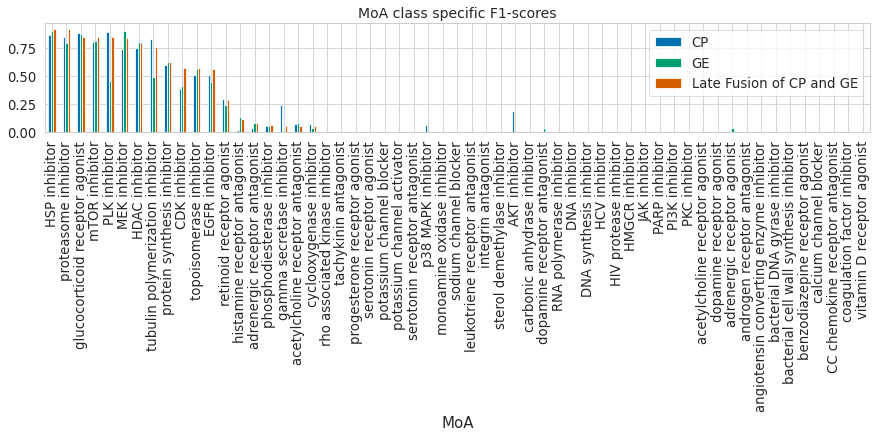

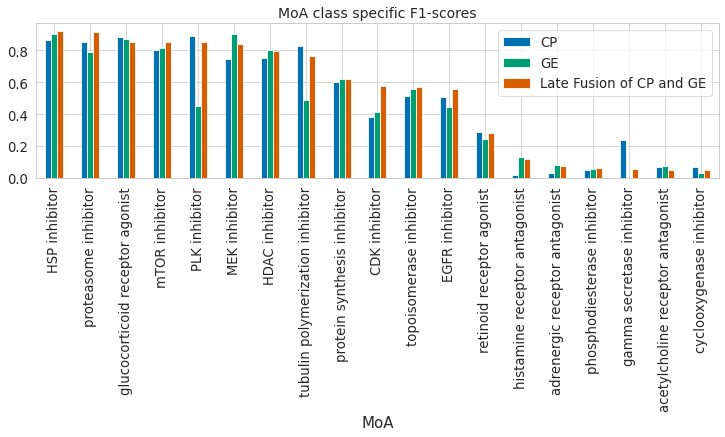

In [39]:
%matplotlib inline
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
report_clss3['f1-score-cp']=report_clss_cp.loc[report_clss3.index]['f1-score'].values
report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
report_clss4=report_clss3[['f1-score-cp','f1-score-ge','f1-score']]
report_clss4=report_clss4.rename(columns={'f1-score-cp':'CP','f1-score-ge':'GE','f1-score':'Late Fusion of CP and GE'})
report_clss4.index=report_clss3['MoA']
ax = report_clss4.plot.bar(rot=90,figsize=(12,6))
plt.title('MoA class specific F1-scores')
plt.tight_layout()

# ax = report_clss4[:15].plot.bar(rot=90,figsize=(7,7))
ax =report_clss4[report_clss4["Late Fusion of CP and GE"]>0].plot.bar(rot=90,figsize=(10,6))
plt.title('MoA class specific F1-scores')
plt.tight_layout()
# plt.savefig('moa_class_spacific_bar.eps')

In [40]:
report_clss4[report_clss4["Late Fusion of CP and GE"]>0].shape

(19, 3)

<IPython.core.display.Javascript object>


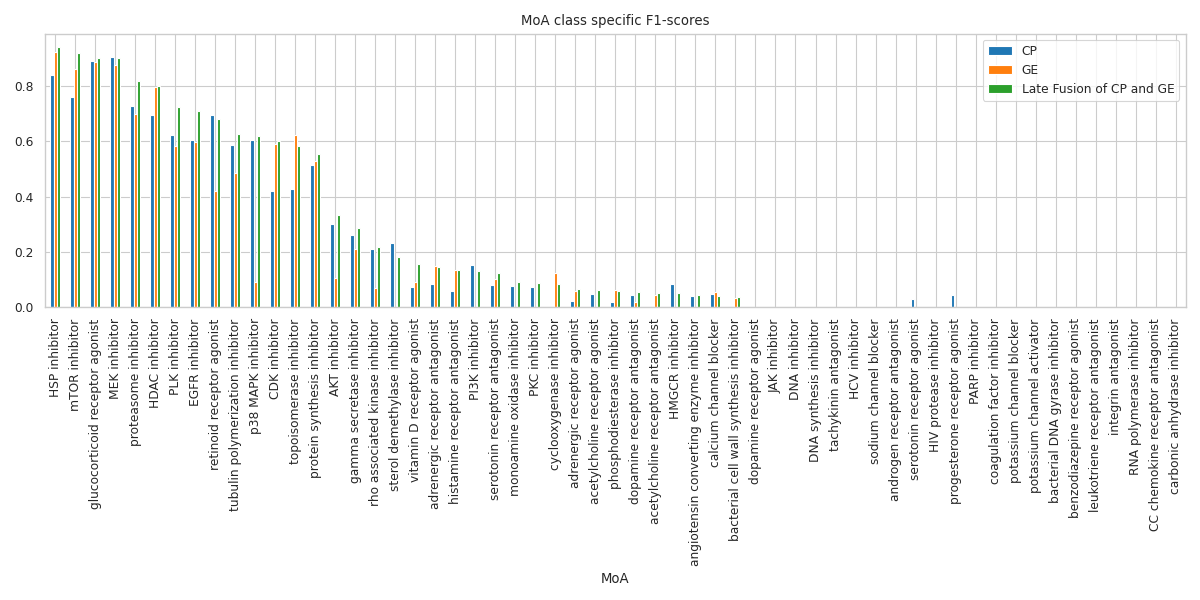

In [16]:
sns.set_context("paper")
sns.set_style("whitegrid")
report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
report_clss3['f1-score-cp']=report_clss_cp.loc[report_clss3.index]['f1-score'].values
report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
report_clss4=report_clss3[['f1-score-cp','f1-score-ge','f1-score']]
report_clss4=report_clss4.rename(columns={'f1-score-cp':'CP','f1-score-ge':'GE','f1-score':'Late Fusion of CP and GE'})
report_clss4.index=report_clss3['MoA']
ax = report_clss4.plot.bar(rot=90,figsize=(12,6))
plt.title('MoA class specific F1-scores')
plt.tight_layout()

<ipython-input-31-2fee80cc043b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report_clss2['support']=report_clss2['support'].astype(int)
<ipython-input-31-2fee80cc043b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report_clss2['n_samples']=report_clss2['support']


/tmp/ipykernel_26330/1957627662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report_clss2['support']=report_clss2['support'].astype(int)
/tmp/ipykernel_26330/1957627662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report_clss2['n_samples']=report_clss2['support']


<IPython.core.display.Javascript object>


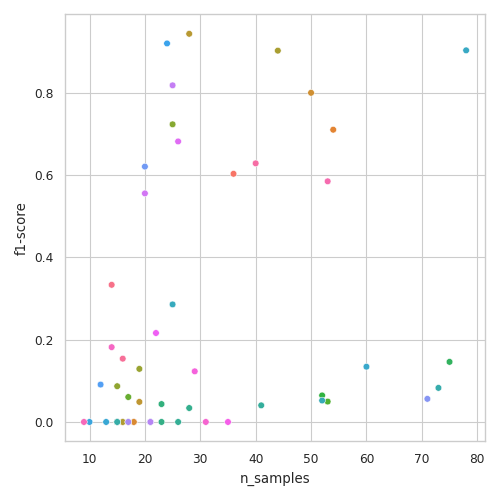

In [20]:
report_clss2['support']=report_clss2['support'].astype(int)
report_clss2['n_samples']=report_clss2['support']

plt.figure(figsize=(5,5))
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.scatterplot(data=report_clss2, x="n_samples", y="f1-score", hue="MoA",legend=False)
plt.tight_layout()# p
# plt.savefig('moa_class_scatter.eps')

In [266]:
# scores_mlp
report_clss2

,precision,recall,f1-score,support,MoA,n_samples
0,0.958333,0.741935,0.836364,31,CDK inhibitor,31
1,0.666667,1.000000,0.800000,16,EGFR inhibitor,16
2,1.000000,0.969697,0.984615,33,HDAC inhibitor,33
3,1.000000,1.000000,1.000000,23,HSP inhibitor,23
4,1.000000,0.909091,0.952381,33,MEK inhibitor,33
5,0.111111,0.125000,0.117647,8,acetylcholine receptor antagonist,8
6,0.000000,0.000000,0.000000,10,adrenergic receptor antagonist,10
7,0.117647,0.181818,0.142857,11,cyclooxygenase inhibitor,11
8,1.000000,0.971429,0.985507,70,glucocorticoid receptor agonist,70
9,0.083333,0.111111,0.095238,9,histamine receptor antagonist,9


<IPython.core.display.Javascript object>


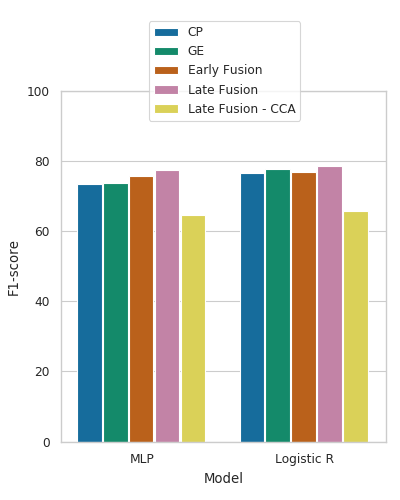

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [176]:
# ax = sns.catplot(x="Modality", y="F1-score",
#                  col="Model",
#                 data=res_df, kind="bar",
#                 height=4, aspect=.7);
# kwargs = {"width":0.2}
import matplotlib.style as style
style.use('seaborn-colorblind')
res_df1=res_df[res_df['Modality']!='Early Fusion']
res_df2=res_df[res_df['Modality']!='Late Fusion']

sns.set_context("paper")
sns.set_style("whitegrid")
plt.figure(figsize=(4,5))
ax = sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df)#,**kwargs)
# ax = sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df2)
# ax.legend(ncol = 1, loc = 'upper center')
# plt.legend(loc='top', borderaxespad=0)
plt.legend(bbox_to_anchor=(0.27, 1.2), loc='upper left', borderaxespad=0)
plt.tight_layout()
ax.set_ylim(0,100)

for a in ax.patches:
    a.set_width(0.15)
plt.savefig('moa_class_bar.eps')

<IPython.core.display.Javascript object>


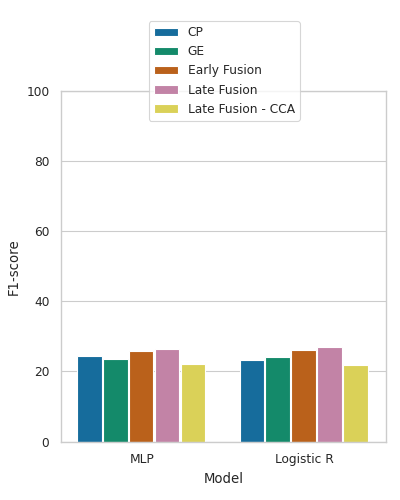

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [25]:
# ax = sns.catplot(x="Modality", y="F1-score",
#                  col="Model",
#                 data=res_df, kind="bar",
#                 height=4, aspect=.7);
# kwargs = {"width":0.2}
import matplotlib.style as style
style.use('seaborn-colorblind')
res_df1=res_df[res_df['Modality']!='Early Fusion']
res_df2=res_df[res_df['Modality']!='Late Fusion']

sns.set_context("paper")
sns.set_style("whitegrid")
plt.figure(figsize=(4,5))
ax = sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df)#,**kwargs)
# ax = sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df2)
# ax.legend(ncol = 1, loc = 'upper center')
# plt.legend(loc='top', borderaxespad=0)
plt.legend(bbox_to_anchor=(0.27, 1.2), loc='upper left', borderaxespad=0)
plt.tight_layout()
ax.set_ylim(0,100)

for a in ax.patches:
    a.set_width(0.15)
plt.savefig('moa_class_bar.eps')

<IPython.core.display.Javascript object>


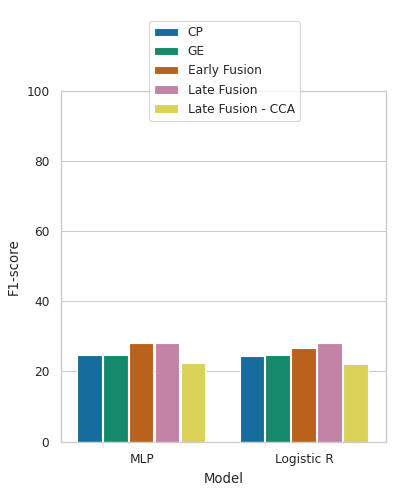

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [100]:
# ax = sns.catplot(x="Modality", y="F1-score",
#                  col="Model",
#                 data=res_df, kind="bar",
#                 height=4, aspect=.7);
# kwargs = {"width":0.2}
import matplotlib.style as style
style.use('seaborn-colorblind')
res_df1=res_df[res_df['Modality']!='Early Fusion']
res_df2=res_df[res_df['Modality']!='Late Fusion']

sns.set_context("paper")
sns.set_style("whitegrid")
plt.figure(figsize=(4,5))
ax = sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df)#,**kwargs)
# ax = sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df2)
# ax.legend(ncol = 1, loc = 'upper center')
# plt.legend(loc='top', borderaxespad=0)
plt.legend(bbox_to_anchor=(0.27, 1.2), loc='upper left', borderaxespad=0)
plt.tight_layout()
ax.set_ylim(0,100)

for a in ax.patches:
    a.set_width(0.15)
plt.savefig('moa_class_bar.eps')

In [162]:
# merged_scaled

# moa_col
# DataFuseResults_filt.mean()
plt.figure()
sns.scatterplot(data=described_data['CP'], x="count", y="mean", hue="Metadata_MoA",legend=False)
plt.tight_layout()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [93]:
DataFuseResults_filt=saved_scores['fuseConcat-LINCS-nvs-filt'].rename(columns={'Unnamed: 0':'Compounds'})
DataFuseResults_filt=pd.merge(DataFuseResults_filt,merged_scaled[['Compounds',moa_col]],how='left',on=['Compounds'])
DataFuseResults_filt['n_moa_cats']=DataFuseResults_filt[moa_col].apply(lambda x: len(x.split('|')))
DataFuseResults_filt2=DataFuseResults_filt[DataFuseResults_filt['n_moa_cats']<2]

DataFuseResults_filt2['Data']='Filtered Samples'


DataFuseResults_all=saved_scores['fuseConcat-LINCS-nvs-']
DataFuseResults_all['Data']='All Samples'

DataFuseResults_filt_cca=saved_scores['fuseCCA-LINCS-nvs-filt']
DataFuseResults_filt_cca['Data']='Filtered Samples - CCA'

DataFuseResults_all_cca=saved_scores['fuseCCA-LINCS-nvs-']
DataFuseResults_all_cca['Data']='All Samples - CCA'

DataFuseResults_filt_snf=saved_scores['fuseSNF-LINCS-nvs-filt']
DataFuseResults_filt_snf['Data']='Filtered Samples - SNF'

DataFuseResults_all_snf=saved_scores['fuseSNF-LINCS-nvs-']
DataFuseResults_all_snf['Data']='All Samples - SNF'

<ipython-input-93-d0099a2316db>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataFuseResults_filt2['Data']='Filtered Samples'


<IPython.core.display.Javascript object>


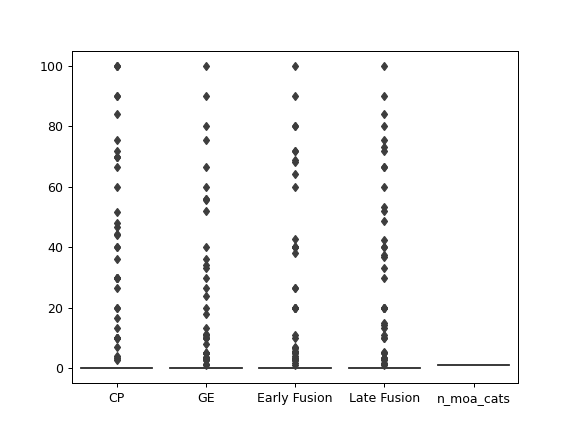

In [81]:
# merged_scaled
plt.figure()
sns.boxplot(data=DataFuseResults_filt2.groupby([moa_col]).mean())

<IPython.core.display.Javascript object>


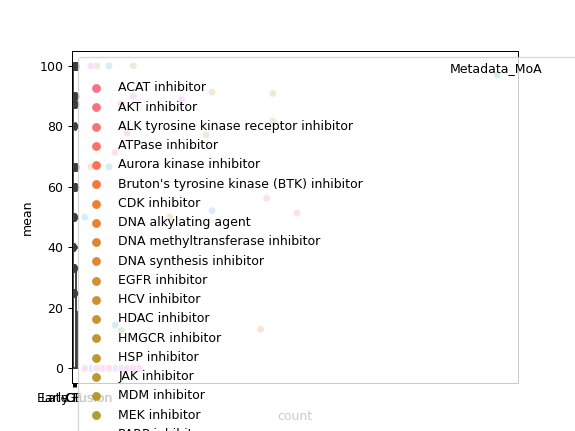

In [56]:
plt.figure()
sns.boxplot(data=DataFuseResults_filt2.groupby([moa_col]).median())

In [82]:
described_data=DataFuseResults_filt2.groupby([moa_col]).describe()

In [79]:
# plt.figure()
# sns.scatterplot(data=described_data['CP'], x="count", y="mean", hue="Metadata_MoA",legend=False)


<IPython.core.display.Javascript object>


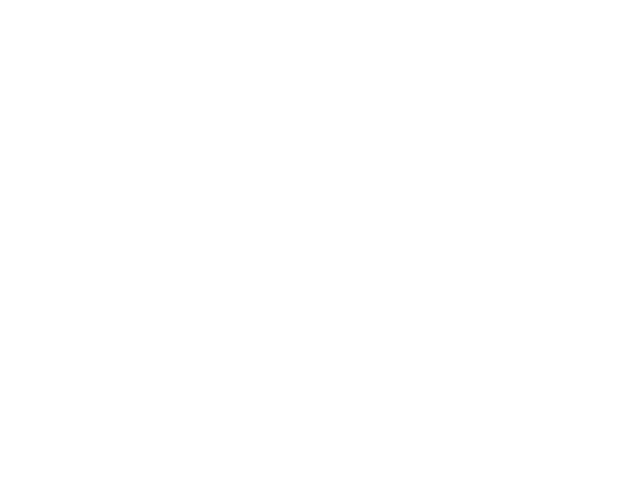

NameError: name 'described_data' is not defined

In [101]:
plt.figure()
sns.scatterplot(data=described_data['CP'], x="count", y="mean", hue="Metadata_MoA",legend=False)
plt.tight_layout()# pd.merge(DataFuseResults_filt,merged_scaled[['Compounds',moa_col]],how='left',on=['Compounds'])

In [36]:
# pd.melt(DataFuseResults_filt)#.rename(columns={'variable':'lmGens','value':'pred score'})
# plt.figure()
sns.boxplot(data=DataFuseResults_all_snf)
# merged_scaled[['PERT',moa_col]]

,PERT,Metadata_MoA
0,BRD-A00147595_0.04,insulin sensitizer|PPAR receptor partial agonist
1,BRD-A00147595_0.12,insulin sensitizer|PPAR receptor partial agonist
2,BRD-A00147595_0.37,insulin sensitizer|PPAR receptor partial agonist
3,BRD-A00147595_1.11,insulin sensitizer|PPAR receptor partial agonist
4,BRD-A00147595_3.33,insulin sensitizer|PPAR receptor partial agonist
...,...,...
6980,BRD-M89827113_0.12,potassium channel activator
6981,BRD-M89827113_0.37,potassium channel activator
6982,BRD-M89827113_1.11,potassium channel activator
6983,BRD-M89827113_3.33,potassium channel activator


In [27]:
# DataFuseResults_all_snf

In [24]:
DataFuseResults_filt_cca.describe()

,CP,GE,Early Fusion,Late Fusion
count,752.000000,752.000000,752.000000,752.000000
mean,23.936170,12.500000,19.148936,19.281915
std,36.593439,22.141257,30.360798,30.029847
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,40.000000,20.000000,40.000000,40.000000
max,100.000000,100.000000,100.000000,100.000000


In [ ]:
# DataFuseResults=DataFuseResults_loaded.copy()
DataFuseResults=DataFuseResults.rename(columns={'acc':'Accuracy'})

fig, axes = plt.subplots(1,4,figsize=(10,5))
sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples'],\
            palette="Set1",ax=axes[0])
axes[0].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[0].set_ylim(0,20)
axes[0].set_title('(a)');

sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='Filtered Samples'],\
            palette="Set1",ax=axes[1])
axes[1].axhline(y=(1/179)*100,linestyle=':',color='r');
axes[1].set_ylim(0,70)
axes[1].set_title('(b)');

sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - CCA'],\
            hue_order=['CP','GE','CP+GE'],palette="Set1",ax=axes[2])
axes[2].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[2].set_ylim(0,20)
axes[2].set_title('(c)');

sns.boxplot(x="Data", y="NMI", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - SNF'],\
            palette="Set1",ax=axes[3])
# axes[3].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[3].set_ylim(10,100)
axes[3].set_title('(d)');
fig.tight_layout()

In [ ]:
sns.boxplot(data=df)

In [ ]:
import matplotlib.style as style
style.use('seaborn-colorblind')
DataFuseResults=DataFuseResults.rename(columns={'acc':'Accuracy'})

hfont = {'fontname':'sans-serif'}

# plt.title('title',**csfont)

fig, axes = plt.subplots(1,3,figsize=(9,6))
fig.suptitle('MoA Classification', fontsize=15,**hfont)

sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples'],\
            ax=axes[0])
axes[0].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[0].set_ylim(0,30)
axes[0].set_title('(a)');

sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='Filtered Samples'],\
            ax=axes[2])
axes[2].axhline(y=(1/179)*100,linestyle=':',color='r');
axes[2].set_ylim(0,100)
axes[2].set_title('(c)');
axes[2].set(ylabel=None)

sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - CCA'],\
            ax=axes[1])
# hue_order=['CP','GE','CP+GE']
axes[1].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[1].set_ylim(0,30)
axes[1].set_title('(b)');
axes[1].set(ylabel=None)

# sns.boxplot(x="Data", y="NMI", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - SNF'],\
#             palette="cividis",ax=axes[3])
# # axes[3].axhline(y=(1/557)*100,linestyle=':',color='r');
# axes[3].set_ylim(0,100)
# axes[3].set_title('(d)');
# fig.tight_layout()
fig.savefig('moa_clussif.eps')

<IPython.core.display.Javascript object>


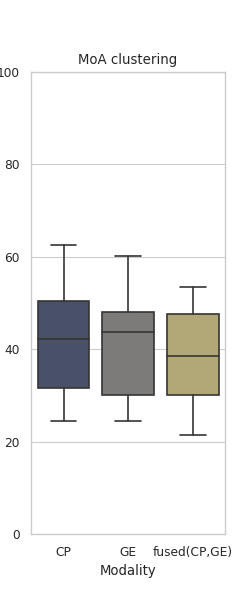

In [338]:
fig, axes = plt.subplots(1,1,figsize=(2.5,6))
# fig.suptitle('MoA Clustering', fontsize=15,**hfont)
# moa_pred_res_snf['NMI']=moa_pred_res_snf['NMI']*100
sns.boxplot(x="Modality",y="NMI",data=moa_pred_res_snf,\
            palette="cividis",ax=axes)
# axes[3].axhline(y=(1/557)*100,linestyle=':',color='r');
axes.set_ylim(0,100)
axes.set_title('MoA clustering');
# fig.tight_layout()
fig.savefig('moa_clustering.eps',bbox_inches='tight')